# Check predictions

In [1]:
from pathlib import Path
import sys

import numpy as np
import pandas as pd

import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

sys.path.insert(0, (Path(".").resolve().parent / "tensorpack-FasterRCNN").as_posix())

In [2]:
from PIL import Image
# !pip3 install --upgrade git+https://github.com/vfdev-5/ImageDatasetViz
from image_dataset_viz import render_datapoint, bbox_to_points

In [3]:
DATA_PATH = Path(".").resolve().parent / "input"

VALIDATION_IMAGES_PATH = DATA_PATH / "validation"
VALIDATION_ANNOTATIONS_CSV_PATH = DATA_PATH / "validation-annotations-bbox.csv"
VALIDATION_CONFIDENCE_CSV_PATH = DATA_PATH / "validation-annotations-human-imagelabels-boxable.csv"
VALIDATION_IMGINFO_CSV_PATH = DATA_PATH / "validation-images-with-rotation.csv"
LABELS_DESCRIPTION_CSV_PATH = DATA_PATH / "class-descriptions-boxable.csv"

TEST_IMAGES_PATH = DATA_PATH / "test"
TEST_ANNOTATIONS_CSV_PATH = DATA_PATH / "test-annotations-bbox.csv"
TEST_CONFIDENCE_CSV_PATH = DATA_PATH / "test-annotations-human-imagelabels-boxable.csv"

In [4]:
images_path = VALIDATION_IMAGES_PATH
annotations_path = VALIDATION_ANNOTATIONS_CSV_PATH

# images_path = TEST_IMAGES_PATH
# annotations_path = TEST_ANNOTATIONS_CSV_PATH

In [5]:
annotations = pd.read_csv(annotations_path, index_col="ImageID")
labels_description = pd.read_csv(LABELS_DESCRIPTION_CSV_PATH, header=None)
annotations['LabelName'] = annotations['LabelName'].map(labels_description.set_index(0)[1])

xyxy_cols = ['XMin', 'YMin', 'XMax', 'YMax']
meta_cols = ['IsOccluded', 'IsTruncated', 'IsGroupOf', 'IsDepiction', 'IsInside']


def get_bboxes_labels_meta(canvas_size, image_id):
    bboxes = annotations.loc[image_id, xyxy_cols].values
    labels = annotations.loc[image_id, 'LabelName']
    meta = annotations.loc[image_id, meta_cols].values
    
    if bboxes.ndim == 1:
        bboxes = bboxes[None, :]
        meta = meta[None, :]
    
    if isinstance(labels, str):        
        labels = np.array([labels, ])
    bboxes[:, 0] *= canvas_size[0]
    bboxes[:, 2] *= canvas_size[0]    
    bboxes[:, 1] *= canvas_size[1]
    bboxes[:, 3] *= canvas_size[1]
    return bboxes, labels, meta

In [6]:
labels = labels_description[1].values.tolist()
image_ids = annotations.index.unique()

Show groundtruth

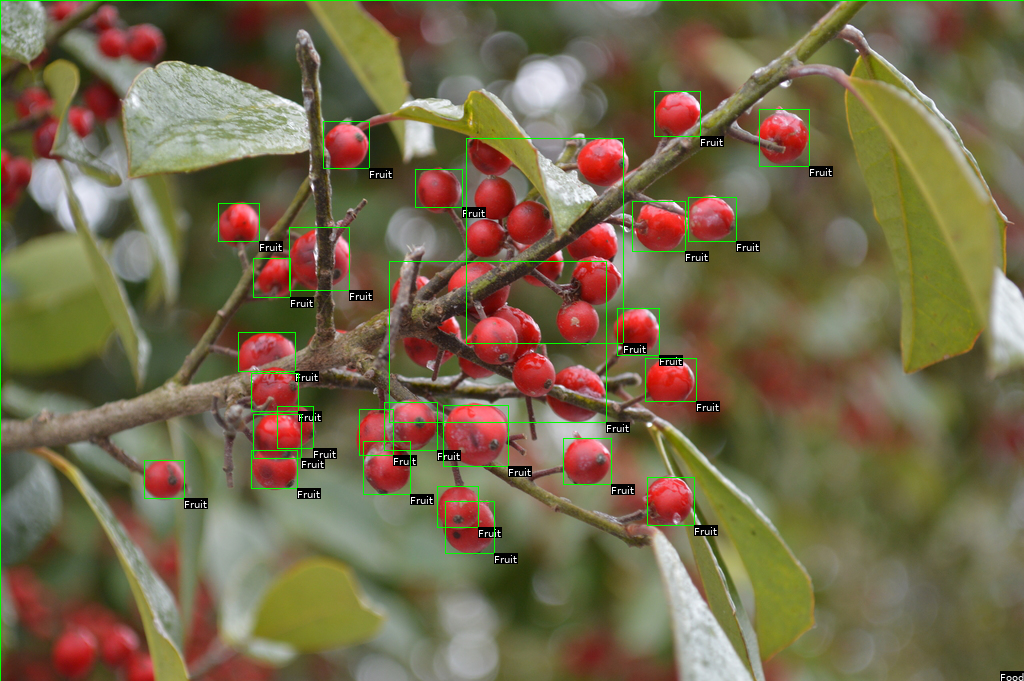

In [7]:
image_id = image_ids[1]

image_path = (images_path / "{}.jpg".format(image_id)).as_posix()

img = Image.open(image_path)
if img.mode == "L":
    img = img.convert('RGB')
targets = [(bbox_to_points(b), l) for b, l, _ in zip(*get_bboxes_labels_meta(img.size, image_id))]
render_datapoint(img, targets)

Run predictions

In [11]:
model_path = "/home/storage_ntfs_1tb/OpenImagesObjectDetections/output/20180708_0754/model-10000.index"

config_str = "MODE_MASK=False MODE_FPN=True DATA.BASEDIR=../input/as_mscoco"

In [16]:

!cd ../tensorpack-FasterRCNN && python3 train.py --predict {image_path} --load {model_path} --config {config_str}



/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
[0708 08:53:45 @config.py:190] Config: ------------------------------------------
{'BACKBONE': {'FREEZE_AFFINE': False,
              'NORM': 'FreezeBN',
              'RESNET_NUM_BLOCK': [3, 4, 6, 3],
              'STRIDE_1X1': False,
              'TF_PAD_MODE': True,
              'WEIGHTS': ''},
 'DATA': {'BASEDIR': '../input/as_mscoco',
          'CLASS_NAMES': [],
          'NUM_CATEGORY': 601,
          'NUM_CLASS': 602,
          'TRAIN': ['test'],
          'VAL': 'val'},
 'FPN': {'ANCHOR_STRIDES': (4, 8, 16, 32, 64),
         'FRCNN_CONV_HEAD_DIM': 256,
         'FRCNN_FC_HEAD_DIM': 1024,
         'FRCNN_HEAD_FUNC': 'fastrcnn_2fc_head',
         'NUM_CHANNEL': 256,
         'R